In [29]:
import sys
import os
import subprocess
import re
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
import traceback
import hashlib
import math
import collections
import functools

import sklearn.preprocessing
import sklearn.feature_selection
import sklearn.ensemble 
import sklearn.neural_network
import sklearn.model_selection
import sklearn.metrics
import sklearn.pipeline
from sklearn.externals import joblib

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import event_processing_v3
import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

import tool.acqconv
from data_analysis_utils import *
from data_analysis_utils_dataframes import *
from data_analysis_utils_performance import *
# import supervised_classification as supc    

Welcome to JupyROOT 6.13/02


# Selecting the simu data

In [3]:
model_data_snippets_dir = 'ver4_machine_learning_w_labeled_flight_20181129'
data_snippets_dir = 'ver4_machine_learning_flight_classification'

# os.makedirs(data_snippets_dir, exist_ok=True)

In [4]:
event_processing_cls = event_processing_v4.EventProcessingV4
event_v3_storage_provider_simu = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config_simu_w_flatmap.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_cls
)

query_functions_simu = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider_simu)

## Columns

In [5]:
rfecv_selector_on_extra_trees__column_names = []

columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names.txt')
print(columns_list_file_pathname)
with open(columns_list_file_pathname, 'r') as columns_list_file:
    rfecv_selector_on_extra_trees__column_names = columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20181129/rfecv_selector_on_extra_trees__column_names.txt


In [6]:
rfecv_selector_on_extra_trees__column_names__special = []

special_columns_list_file_pathname = os.path.join(model_data_snippets_dir, 'rfecv_selector_on_extra_trees__column_names__special.txt')
print(special_columns_list_file_pathname)
with open(special_columns_list_file_pathname, 'r') as special_columns_list_file:
    rfecv_selector_on_extra_trees__column_names__special = special_columns_list_file.read().splitlines()

ver4_machine_learning_w_labeled_flight_20181129/rfecv_selector_on_extra_trees__column_names__special.txt


In [7]:
# This should be empty for now
rfecv_selector_on_extra_trees__column_names__special

[]

In [9]:
simu_columns_for_analysis_dict = query_functions_simu.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=('^.+$',),
    default_excluded_columns_re_list=[],
    included_columns_re_list=\
        [('^$','source_file_(acquisition|trigger)(_full)?|global_gtu|packet_id|gtu_in_packet|event_id|num_gtu')] + \
        rfecv_selector_on_extra_trees__column_names
)
print_columns_dict(simu_columns_for_analysis_dict)

spb_processing_v4_simu_flatmap.event
	- event_id
	- source_file_acquisition_full
	- source_file_trigger_full
	- source_file_acquisition
	- source_file_trigger
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4_simu_flatmap.event_trg_x_y_clusters
	- clu_areas_max
	- max_size_clu_width
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_trg_gtu_x_clusters
	- max_size_clu_height
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_trg_gtu_y_clusters
	- max_size_clu_height
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_orig_x_y
	- count_nonzero

spb_processing_v4_simu_flatmap.event_proc2_x_y_clusters
	- max_peak_clu_width

spb_processing_v4_simu_flatmap.event_proc3_x_y_clusters
	- max_size_clu_height
	- max_peak_clu_width
	- max_peak_clu_height

spb_processing_v4_simu_flatmap.event_proc2_gtu_y_clusters
	- max_size_clu_height

spb_processing_v4_simu_flatmap.event_bg_x_y
	- count_nonzero

spb_p

## Constructing the query

In [10]:
source_data_type_num_classification = 3001
source_data_type_num_filter = 1001

In [37]:
current_columns_for_analysis_dict = simu_columns_for_analysis_dict

common_select_clause_str, common_tables_list = \
    query_functions_simu.get_query_clauses__select(current_columns_for_analysis_dict)

simu_where_clauses_format = \
'''
AND {does_exist} EXISTS (
    SELECT e2.event_id FROM spb_processing_v4_simu_flatmap.event AS e2 
    WHERE 
        e2.source_data_type_num={source_data_type_num:d} 
        AND spb_processing_v4_simu_flatmap.event.source_file_acquisition=e2.source_file_acquisition 
        AND (
            (spb_processing_v4_simu_flatmap.event.gtu_in_packet <= e2.gtu_in_packet AND e2.gtu_in_packet - spb_processing_v4_simu_flatmap.event.gtu_in_packet < spb_processing_v4_simu_flatmap.event.num_gtu - 4) 
            OR 
            (e2.gtu_in_packet < spb_processing_v4_simu_flatmap.event.gtu_in_packet AND spb_processing_v4_simu_flatmap.event.gtu_in_packet - e2.gtu_in_packet < e2.num_gtu - 4)
        )
)
'''

simu_where_clauses_str = simu_where_clauses_format.format(does_exist='', source_data_type_num=source_data_type_num_filter)

joined_select_clause_str = common_select_clause_str + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event.{}'.format(attr) for attr in [
        'simu2npy_pathname', 'edetector_numphotons', 'edetector_numcellhits', 'edetector_numfee', 'eptttrigger_fnumtrigg', 
        'etruth_trueenergy', 'etruth_truetheta', 'etruth_truephi', 'egeometry_pos_z'
    ]]) + ', ' + \
    ', '.join(['{{database_schema_name}}.simu_event_additional.{}'.format(attr) for attr in [
        'num_frames_counts_gt_bg', 'num_frames_signals_gt_bg', 'num_frames_signals_ge_bg'
    ]])

joined_tables_list = common_tables_list + [
    ('{database_schema_name}.simu_event_relation','{data_table_name}','event_id'),
    ('{database_schema_name}.simu_event_additional','{database_schema_name}.simu_event_relation','relation_id'),
    ('{database_schema_name}.simu_event','{database_schema_name}.simu_event_relation','simu_event_id'),
]

join_clauses_str = \
    query_functions_simu.get_query_clauses__join(joined_tables_list)


simu_events_selection_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num_classification,
    select_additional=joined_select_clause_str, 
    join_additional=join_clauses_str,
    where_additional=simu_where_clauses_str,
    order_by='{data_table_name}.event_id', 
    offset=0, limit=350000,
    base_select='')

print(simu_events_selection_query)


    SELECT 
        
        spb_processing_v4_simu_flatmap.event.event_id, spb_processing_v4_simu_flatmap.event.source_file_acquisition_full, spb_processing_v4_simu_flatmap.event.source_file_trigger_full, spb_processing_v4_simu_flatmap.event.source_file_acquisition, spb_processing_v4_simu_flatmap.event.source_file_trigger, spb_processing_v4_simu_flatmap.event.global_gtu, spb_processing_v4_simu_flatmap.event.packet_id, spb_processing_v4_simu_flatmap.event.gtu_in_packet, spb_processing_v4_simu_flatmap.event.num_gtu, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.clu_areas_max AS trg_x_y_clusters_clu_areas_max, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_size_clu_width AS trg_x_y_clusters_max_size_clu_width, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_size_clu_height AS trg_x_y_clusters_max_size_clu_height, spb_processing_v4_simu_flatmap.event_trg_x_y_clusters.max_peak_clu_width AS trg_x_y_clusters_max_peak_clu_width, spb_processing_v4_simu_flatmap.eve

In [40]:
count_filtered_out_query = query_functions_simu.get_events_selection_query_plain(
    source_data_type_num=source_data_type_num_classification,
    select_additional='COUNT(*)', 
    join_additional='',
    where_additional=simu_where_clauses_format.format(does_exist='NOT', source_data_type_num=source_data_type_num_filter),
    order_by=None, 
    offset=0, limit=350000,
    base_select='')

print(count_filtered_out_query)


    SELECT 
        
        COUNT(*)
     FROM spb_processing_v4_simu_flatmap.event
     
    WHERE
        source_data_type_num = 3001
        
AND NOT EXISTS (
    SELECT e2.event_id FROM spb_processing_v4_simu_flatmap.event AS e2 
    WHERE 
        e2.source_data_type_num=1001 
        AND spb_processing_v4_simu_flatmap.event.source_file_acquisition=e2.source_file_acquisition 
        AND (
            (spb_processing_v4_simu_flatmap.event.gtu_in_packet <= e2.gtu_in_packet AND e2.gtu_in_packet - spb_processing_v4_simu_flatmap.event.gtu_in_packet < spb_processing_v4_simu_flatmap.event.num_gtu - 4) 
            OR 
            (e2.gtu_in_packet < spb_processing_v4_simu_flatmap.event.gtu_in_packet AND spb_processing_v4_simu_flatmap.event.gtu_in_packet - e2.gtu_in_packet < e2.num_gtu - 4)
        )
)

    ORDER BY None
    OFFSET 0 LIMIT 350000
    


## Selecting the data

In [19]:
simu_bgf1_df = psql.read_sql(simu_events_selection_query, event_v3_storage_provider_simu.connection)

In [20]:
simu_bgf1_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_clu_areas_max,...,edetector_numcellhits,edetector_numfee,eptttrigger_fnumtrigg,etruth_trueenergy,etruth_truetheta,etruth_truephi,egeometry_pos_z,num_frames_counts_gt_bg,num_frames_signals_gt_bg,num_frames_signals_ge_bg
0,11464,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,84,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
1,11465,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,163,1,35,24,138,...,0,35283,1,1.000000e+13,0.696797,4.65066,27000000.0,16.0,16.0,16.0
2,11486,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,78,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,2.0,2.0,2.0
3,11487,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,84,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0
4,11499,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,/home/spbproc/SPBDATA_processed/spb_simu/posz_...,posz_27000000.00/energy_1.00e+13/thousnd27E20....,posz_27000000.00/energy_1.00e+13/thousnd27E20....,169,1,41,11,84,...,0,29810,1,1.000000e+13,1.311530,2.02739,27000000.0,3.0,3.0,3.0


## Adding additional information

In [23]:
add_bin_column(simu_bgf1_df, 'num_frames_signals_ge_bg', 5);

In [25]:
simu_bgf1_df['is_visible'] = \
    (simu_bgf1_df['num_frames_signals_ge_bg'] >= 2) & (simu_bgf1_df['num_frames_signals_ge_bg'] <= 999) & \
    (32 <= simu_bgf1_df['gtu_in_packet']) & (simu_bgf1_df['gtu_in_packet'] <= 52)
# TODO 32 <= gtu_in_packet <= 52 range in not ideal

In [34]:
print("len(simu_df)                       ", len(simu_bgf1_df))
print("len(simu_df[simu_df['is_visible']])", len(simu_bgf1_df[simu_bgf1_df['is_visible']]))

len(simu_df)                        18919
len(simu_df[simu_df['is_visible']]) 13535


In [27]:
# [['event_id', 'source_file_acquisition', 'global_gtu', 'packet_id', 'gtu_in_packet', 'num_gtu', 'source_file_acquisition_full']]

simu_signal_data_snippets_dir = 'ver4_simu_signal_data_snippets'
simu_signal_visible_tracks_table_path = os.path.join(simu_signal_data_snippets_dir, 'visible_tracks_table.tsv')
simu_signal_noisy_events_table_path = os.path.join(simu_signal_data_snippets_dir, 'noisy_events_table.tsv')

simu_bgf1_df, unclassified_simu_bgf1_df, track_simu_bgf1_df, noisy_simu_bgf1_df, \
simu_bgf1_signal_track_events_df, simu_bgf1_signal_noisy_events_df = \
    add_classification_columns(simu_bgf1_df, simu_signal_visible_tracks_table_path, simu_signal_noisy_events_table_path)

In [169]:
simu_bgf1_visible_tracks_mask = simu_bgf1_df['is_visible'] & (simu_bgf1_df['cond_selection_simple'] == 'track')

In [172]:
simu_bgf1_tracks_df = simu_bgf1_df[simu_bgf1_df['cond_selection_simple'] == 'track']
simu_bgf1_unclassified_df = simu_bgf1_df[simu_bgf1_df['cond_selection_simple'] == 'unclassified']
simu_bgf1_noise_df = simu_bgf1_df[simu_bgf1_df['cond_selection_simple'] == 'noise']
simu_bgf1_visible_df = simu_bgf1_df[simu_bgf1_df['is_visible']]
simu_bgf1_visible_tracks_df = simu_bgf1_df[simu_bgf1_visible_tracks_mask]

In [193]:
cns = rfecv_selector_on_extra_trees__column_names

simu_bgf1_nonan_df = \
    simu_bgf1_df[
        simu_bgf1_df.isin(
            simu_bgf1_df[cns].dropna()).any(axis=1) ]

simu_bgf1_tracks_nonan_df = \
    simu_bgf1_tracks_df[
        simu_bgf1_tracks_df.isin(
            simu_bgf1_tracks_df[cns].dropna()).any(axis=1) ]

simu_bgf1_unclassified_nonan_df = \
    simu_bgf1_unclassified_df[
        simu_bgf1_unclassified_df.isin(
            simu_bgf1_unclassified_df[cns].dropna()).any(axis=1) ]

simu_bgf1_noise_nonan_df = \
    simu_bgf1_noise_df[
        simu_bgf1_noise_df.isin(
            simu_bgf1_noise_df[cns].dropna()).any(axis=1) ]

simu_bgf1_visible_tracks_nonan_df = \
    simu_bgf1_visible_tracks_df[
        simu_bgf1_visible_tracks_df.isin(
            simu_bgf1_visible_tracks_df[cns].dropna()).any(axis=1) ]


In [194]:
len(simu_bgf1_visible_tracks_df[rfecv_selector_on_extra_trees__column_names].dropna())

13368

In [195]:
print("len(simu_bgf1_df)               ", len(simu_bgf1_df))
print("len(simu_bgf1_tracks_df)        ", len(simu_bgf1_tracks_df))
print("len(simu_bgf1_unclassified_df)  ", len(simu_bgf1_unclassified_df))
print("len(simu_bgf1_noise_df)         ", len(simu_bgf1_noise_df))
print("len(simu_bgf1_visible_tracks_df)", len(simu_bgf1_visible_tracks_df))
print("len(simu_bgf1_visible_tracks_df) / len(simu_bgf1_df)", len(simu_bgf1_visible_tracks_df)/len(simu_bgf1_df))

len(simu_bgf1_df)                18919
len(simu_bgf1_tracks_df)         15246
len(simu_bgf1_unclassified_df)   523
len(simu_bgf1_noise_df)          3150
len(simu_bgf1_visible_tracks_df) 13385
len(simu_bgf1_visible_tracks_df) / len(simu_bgf1_df) 0.7074898250436069


In [196]:
print("len(simu_bgf1_nonan_df)               ", len(simu_bgf1_nonan_df))
print("len(simu_bgf1_tracks_nonan_df)        ", len(simu_bgf1_tracks_nonan_df))
print("len(simu_bgf1_unclassified_nonan_df)  ", len(simu_bgf1_unclassified_nonan_df))
print("len(simu_bgf1_noise_nonan_df)         ", len(simu_bgf1_noise_nonan_df))
print("len(simu_bgf1_visible_tracks_nonan_df)", len(simu_bgf1_visible_tracks_nonan_df))
print("len(simu_bgf1_visible_tracks_nonan_df) / len(simu_bgf1_nonan_df)", len(simu_bgf1_visible_tracks_nonan_df)/len(simu_bgf1_nonan_df))

len(simu_bgf1_nonan_df)                18871
len(simu_bgf1_tracks_nonan_df)         15217
len(simu_bgf1_unclassified_nonan_df)   504
len(simu_bgf1_noise_nonan_df)          3150
len(simu_bgf1_visible_tracks_nonan_df) 13368
len(simu_bgf1_visible_tracks_nonan_df) / len(simu_bgf1_nonan_df) 0.7083885326691749


In [41]:
count_filtered_out_cur = event_v3_storage_provider_simu.connection.cursor()
count_filtered_out_cur.execute(count_filtered_out_query)
count_filtered_out_num = count_filtered_out_cur.fetchone()

ProgrammingError: column "none" does not exist
LINE 22:     ORDER BY None
                      ^


In [ ]:
print('Number of visible events not triggered:',count_filtered_out_num)

In [71]:
simu_bgf1_null_rows_df = simu_bgf1_df[ simu_df[rfecv_selector_on_extra_trees__column_names].isnull().any(axis=1) ]

In [197]:
print('Number L1(bgf=1) triggered simu evens with null rows (dropped):', len(simu_null_rows_df))
print('Number L1(bgf=1) triggered simu evens without null rows (included):', len(simu_nonan_df))

Number L1(bgf=1) triggered simu evens with null rows (dropped): 48
Number L1(bgf=1) triggered simu evens without null rows (included): 18871


In [198]:
pd.set_option('display.max_columns', 200)
simu_null_rows_df.head()

,event_id,source_file_acquisition_full,source_file_trigger_full,source_file_acquisition,source_file_trigger,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_x_y_clusters_clu_areas_max,trg_x_y_clusters_max_size_clu_width,trg_x_y_clusters_max_size_clu_height,trg_x_y_clusters_max_peak_clu_width,trg_x_y_clusters_max_peak_clu_height,trg_gtu_x_clusters_max_size_clu_height,trg_gtu_x_clusters_max_peak_clu_height,trg_gtu_y_clusters_max_size_clu_height,trg_gtu_y_clusters_max_peak_clu_height,orig_x_y_count_nonzero,proc2_x_y_clusters_max_peak_clu_width,proc3_x_y_clusters_max_size_clu_height,proc3_x_y_clusters_max_peak_clu_width,proc3_x_y_clusters_max_peak_clu_height,proc2_gtu_y_clusters_max_size_clu_height,bg_x_y_count_nonzero,alt1_gtu_x_clusters_sizes_max,alt1_gtu_x_clusters_max_peak_clu_size,bg_count_nonzero,bg_size,trg_x_y_hough_peak_thr1_line_clusters_sizes_max,trg_x_y_hough_peak_thr1_line_clusters_clu_widths_max,trg_x_y_hough_peak_thr1_line_clusters_clu_areas_max,trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_x_y_hough_peak_thr1_line_clusters_max_peak_clu_height,trg_x_y_hough_peak_thr1_line_clusters_max_area_clu_size,trg_x_y_hough_peak_thr2_line_clusters_clu_widths_max,trg_x_y_hough_peak_thr2_line_clusters_max_size_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width,trg_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_clu_widths_max,trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_width,trg_gtu_x_hough_peak_thr1_line_clusters_max_area_clu_height,trg_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max,trg_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_size_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,trg_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_count,proc1_x_y_hough_peak_thr1_line_clusters_clu_widths_max,proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_area_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_size_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_height,proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_x_y_hough_peak_thr2_line_clusters_count,proc2_x_y_hough_peak_thr1_line_clusters_count,proc2_x_y_hough_peak_thr1_line_clusters_clu_widths_max,proc2_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,proc2_x_y_hough_peak_thr1_line_clusters_max_area_clu_height,proc2_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc2_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc2_x_y_hough_peak_thr2_line_clusters_count,proc2_x_y_hough_peak_thr3_line_clusters_count,proc3_x_y_hough_peak_thr1_line_clusters_count,proc3_x_y_hough_peak_thr1_line_clusters_clu_widths_max,proc3_x_y_hough_peak_thr1_line_clusters_max_area_clu_width,proc3_x_y_hough_peak_thr1_line_clusters_max_size_clu_width,proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc3_x_y_hough_peak_thr2_line_clusters_count,proc3_x_y_hough_peak_thr3_line_clusters_count,proc1_gtu_x_hough_peak_thr2_major_line_rho,proc1_gtu_x_hough_peak_thr3_major_line_rho,proc3_gtu_x_hough_peak_thr1_line_clusters_count,proc3_gtu_x_hough_peak_thr2_line_clusters_count,proc2_gtu_y_hough_peak_thr1_line_clusters_clu_widths_max,proc2_gtu_y_hough_peak_thr1_line_clusters_max_area_clu_

In [199]:
pd.reset_option('display.max_columns')

# Applying models

## StandardScaler

In [42]:
standard_scaler_on_train_rfecv_columns_pathname = \
     os.path.join(model_data_snippets_dir, 'standard_scaler_on_train_rfecv_columns.pkl')
standard_scaler_on_train_rfecv_columns = joblib.load(standard_scaler_on_train_rfecv_columns_pathname)

In [210]:
simu_bgf1_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

In [211]:
simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_visible_tracks_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

In [223]:
simu_bgf1_tracks_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_tracks_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

In [228]:
simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X = \
    standard_scaler_on_train_rfecv_columns.transform(
        simu_bgf1_unclassified_nonan_df[rfecv_selector_on_extra_trees__column_names].values)

## Extra trees classifier

In [84]:
extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname = \
    os.path.join(model_data_snippets_dir, 'extra_trees_cls_on_train_kbest400_128_est.pkl')
extra_trees_cls_on_train_kbest400_128_est = joblib.load(extra_trees_cls_on_train_kbest400_128_est__model_plk_pathname)

In [86]:
simu_nonan__rfecv_columns_scaled_y_pred = extra_trees_cls_on_train_kbest400_128_est.predict(simu_nonan__rfecv_columns_scaled_X)

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


Evaluation should be done on a different dataset, because this also contains training data

### Sensitivity on L1 (bgf=1) triggered events

- P - all triggered 
- TP - recognized

#### By particle energy

In [212]:
extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


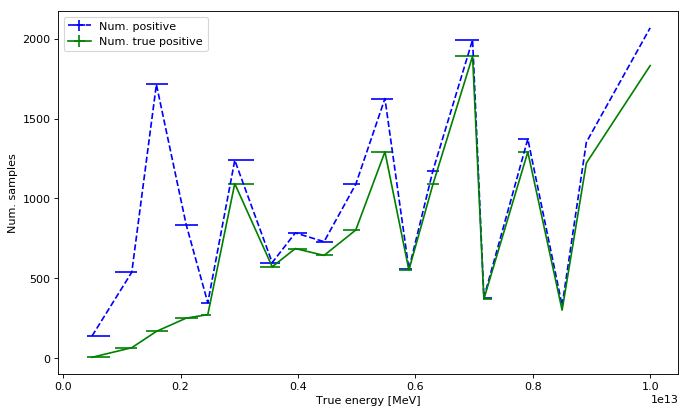

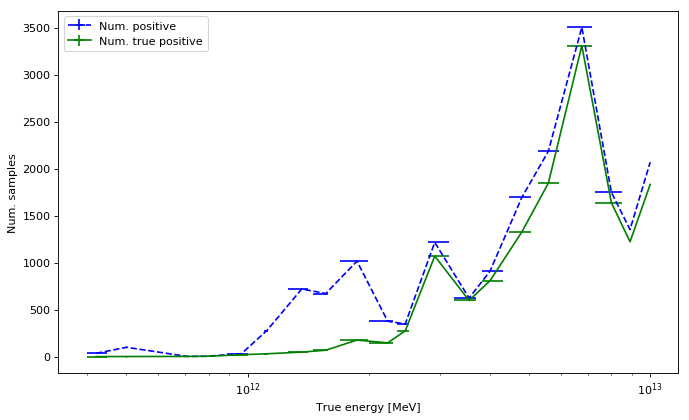

In [213]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

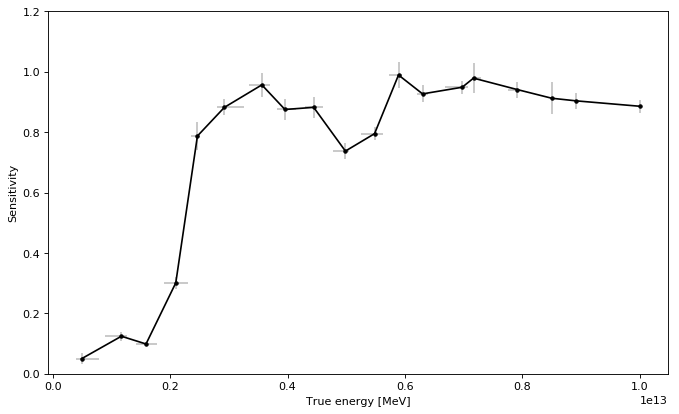

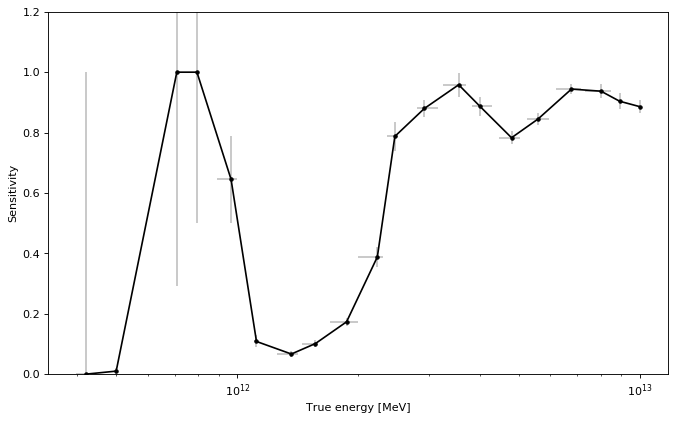

In [214]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

#### By zenith angle (theta)

In [215]:
extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_theta = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truetheta')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


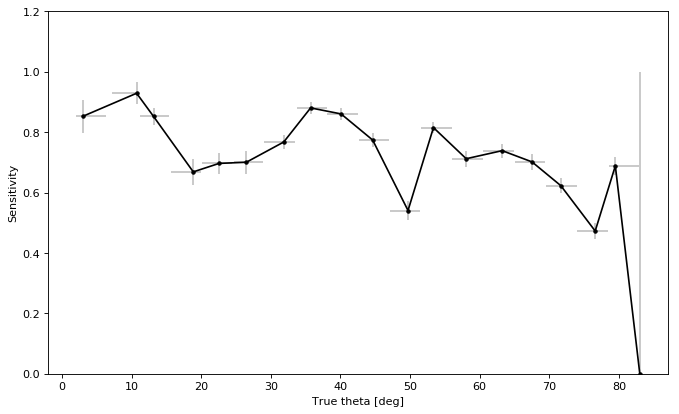

In [216]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_theta, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True theta [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

#### By azimuth angle (phi)

In [217]:
extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_phi = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truephi')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


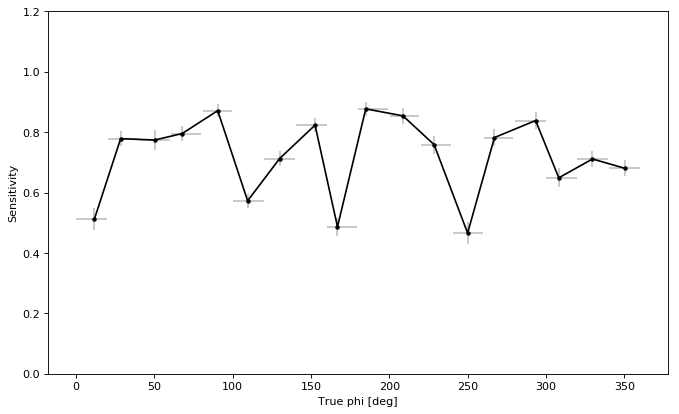

In [218]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1__numbers_by_phi, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True phi [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

### Sensitivity on L1 (bgf=1) triggered *visible track* events

#### By particle energy

In [219]:
extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_visible_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_visible_tracks_nonan_df['event_id'].values, 
        simu_bgf1_visible_tracks_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


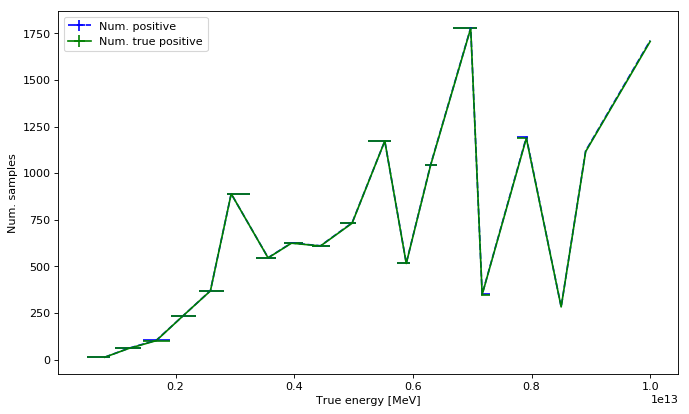

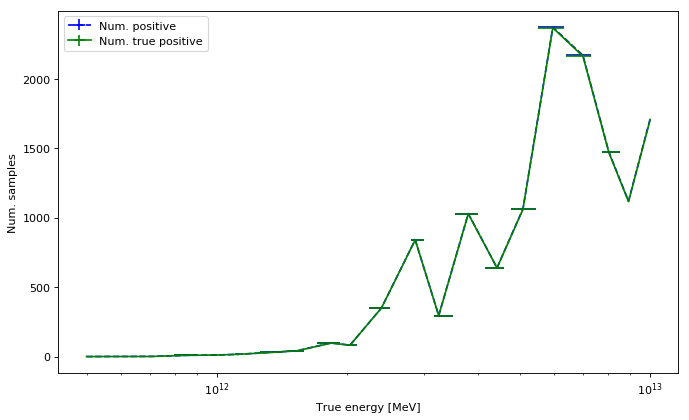

In [220]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

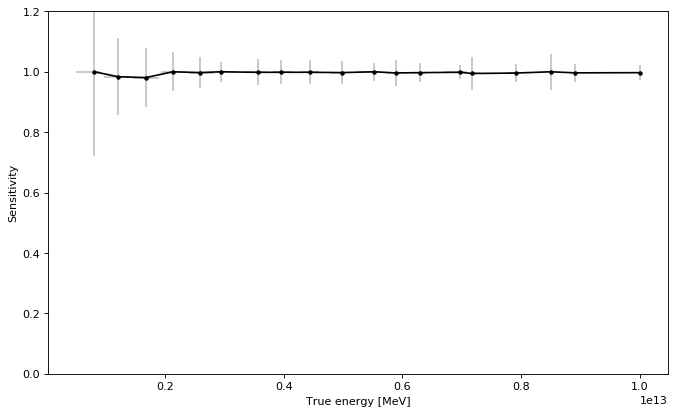

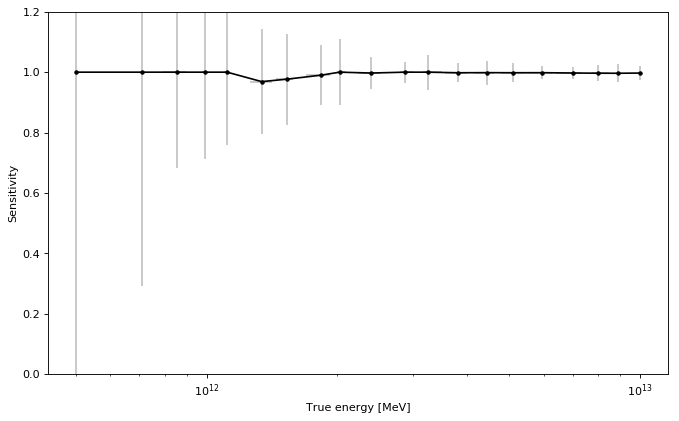

In [221]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_visible_tracks__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

Most of the triggered and visible track events (training and testing data) seem to be selected.

### Sensitivity on L1 (bgf=1) triggered *track* events

#### By particle energy

In [224]:
extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_tracks_nonan_df['event_id'].values, 
        simu_bgf1_tracks_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.1s finished


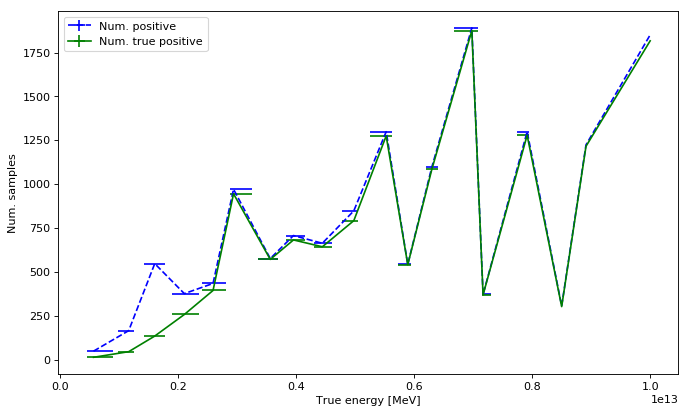

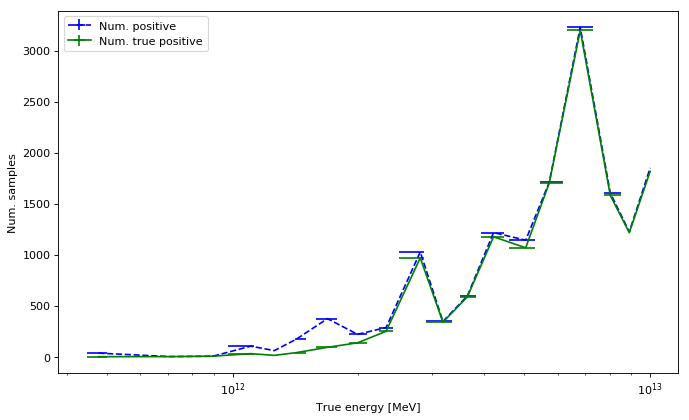

In [225]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. positive', label='Num. positive',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

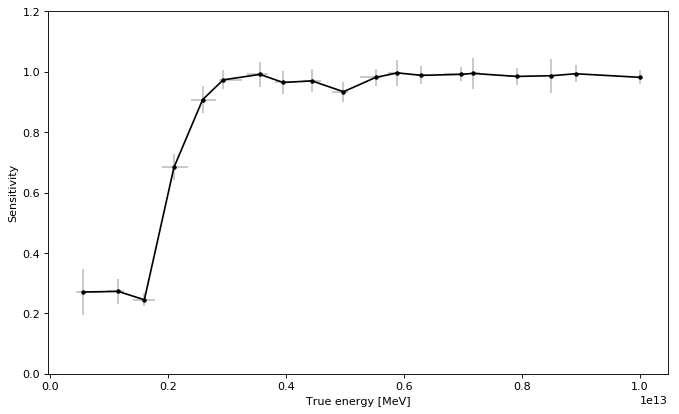

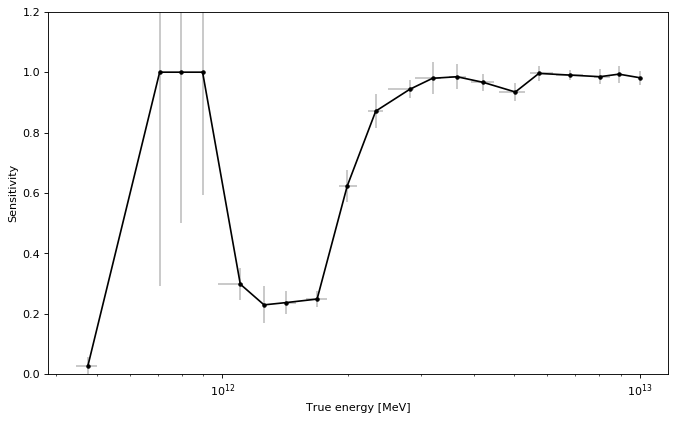

In [226]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))

Low energy track events are not recognized. These events seem not to be a part of visible events dataset (selection).

In [ ]:
# single_proj_width=6 
# single_proj_height=4
# line_alpha=0.0


# # extension_func = lambda i, r, visualized_projections, fig, axs_flattened: \
# #     show_simu_event_row(i, r, print_offset=0, extra_columns=[], vis_xy=True, vis_gtux=True, vis_gtuy=True,
# #                         npy_pathname_column=npy_pathname_column, 
# #                         single_proj_width=single_proj_width, single_proj_height=single_proj_height,
# #                         print_info=False, warn_if_not_exact_simu=False)

# extra_trees_classifier_y_pred_1_event_id = \
#     flight_nonan_event_id__values[extra_trees_classifier_on_train_kbest30__y_flight_pred == 1]

# # events_to_vis_df = flight_df[flight_df['event_id'].isin(flight_nonan_after_vt_kb_event_id__series)].sort_values('rank', ascending=True)
# events_to_vis_df = flight_df[flight_df['event_id'].isin(extra_trees_classifier_y_pred_1_event_id)].sort_values('rank', ascending=True)
# print('len(events_to_vis_df) =', len(events_to_vis_df))
# print('-'*50)

# def print_classification(i, r, visualized_projections, fig, axs_flattened):
#     loc = np.argmax(flight_nonan_event_id__values == r['event_id'])
#     event_id_check = flight_nonan_event_id__values[loc]
#     extra_trees_classifier_y_pred = extra_trees_classifier_on_train_kbest30__y_flight_pred[loc]
# #     mlp_classifier_y_pred = mlp_classifier_on_train_kbest30__y_test_pred[loc]
    
#     print('\t----------------------------------')
#     print('\tloc =', loc )
#     print('\tevent_id_check =', event_id_check )
#     print('\textra_trees_classifier_y_pred =', extra_trees_classifier_y_pred )
# #     print('\tmlp_classifier_y_pred =', mlp_classifier_y_pred )
    

# vis_events_df(
#     events_to_vis_df.iloc[500:], 
#     events_per_figure=20, max_figures=1, vis_gtux=True, vis_gtuy=True, 
#     close_after_vis=False, show=True, 
#     additional_printed_columns=['source_file_acquisition'],
#     line_columns_x_y=vis_events_line_columns_x_y, 
#     line_columns_gtu_x=vis_events_line_columns_gtu_x, 
#     line_columns_gtu_y=vis_events_line_columns_gtu_y,
#     line_colors=vis_events_line_colors, line_alpha=line_alpha,
#     by_one=True,
#     extension_func=print_classification,
#     single_proj_width=single_proj_width, single_proj_height=single_proj_height
# )


# events_to_vis_df = combined_simu_df[combined_simu_df['event_id'].isin(combined_simu_nonan_balanced__event_id_test)].sort_values('rank', ascending=True)
# print('len(events_to_vis_df) =', len(events_to_vis_df))
# print('-'*50)

# def print_classification(i, r, visualized_projections, fig, axs_flattened):
#     loc = np.argmax(combined_simu_nonan_balanced__event_id_test == r['event_id'])
#     event_id_check = combined_simu_nonan_balanced__event_id_test[loc]
#     class_check = combined_simu_nonan_balanced__bin_classes_test[loc]
#     extra_trees_classifier_y_check = extra_trees_classifier_on_train_kbest30__y_test[loc]
#     mlp_classifier_y_check = extra_trees_classifier_on_train_kbest30__y_test_pred[loc]
#     extra_trees_classifier_y_pred = extra_trees_classifier_on_train_kbest30__y_test_pred[loc]
#     mlp_classifier_y_pred = mlp_classifier_on_train_kbest30__y_test_pred[loc]
    
#     print('\t----------------------------------')
#     print('\tloc =', loc )
#     print('\tevent_id_check =', event_id_check )
#     print('\tclass_check =', class_check )
#     print('\textra_trees_classifier_y_check =', extra_trees_classifier_y_check )
#     print('\tmlp_classifier_y_check =', mlp_classifier_y_check )
#     print('\textra_trees_classifier_y_pred =', extra_trees_classifier_y_pred )
#     print('\tmlp_classifier_y_pred =', mlp_classifier_y_pred )
    
# for i in range(0,3):
#     vis_events_df(
#         events_to_vis_df.iloc[i*len(events_to_vis_df)//3:], 
#         events_per_figure=10, max_figures=1, vis_gtux=True, vis_gtuy=True, 
#         close_after_vis=False, show=True, 
#         additional_printed_columns=['cond_selection_combined','num_frames_counts_gt_bg'],
#         line_columns_x_y=vis_events_line_columns_x_y, 
#         line_columns_gtu_x=vis_events_line_columns_gtu_x, 
#         line_columns_gtu_y=vis_events_line_columns_gtu_y,
#         line_colors=vis_events_line_colors, line_alpha=line_alpha,
#         by_one=True,
#         extension_func=print_classification,
#         single_proj_width=single_proj_width, single_proj_height=single_proj_height
#     )

#### By zenith angle (theta)

In [233]:
extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_theta = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_tracks_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truetheta')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


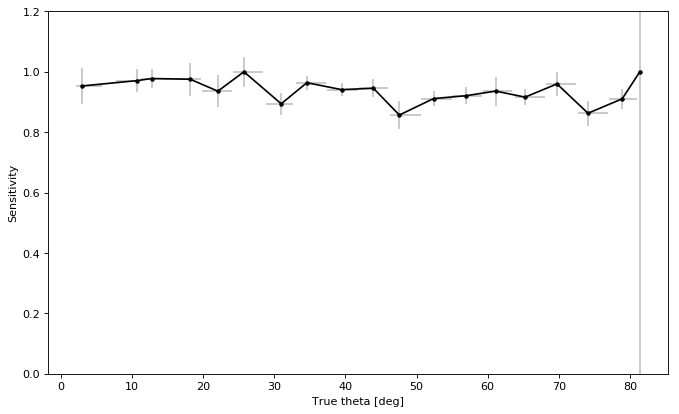

In [234]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_theta, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True theta [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

#### By azimuth angle (phi)

In [236]:
extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_phi = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_tracks_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_tracks_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_tracks_nonan_df['event_id'].values, 
        simu_bgf1_nonan_df, 'etruth_truephi')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


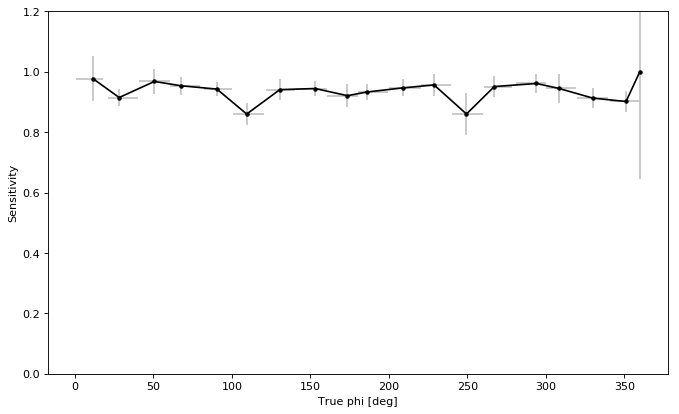

In [237]:
plt.close('all')
plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_tracks__numbers_by_phi, 
                     plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', 
                     num_steps = 90/(2.5*2), xtranslate_func=np.rad2deg, 
                     xscale='linear', xlabel = 'True phi [deg]', ylabel = 'Sensitivity', 
                     figsize = (10,6), ylim=(0,1.2));

### Sensitivity on L1 (bgf=1) triggered *unclassified* events

In [229]:
extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy = \
    score_by_column(
        extra_trees_cls_on_train_kbest400_128_est, 
        simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X, 
        np.ones(len(simu_bgf1_unclassified_nonan__rfecv_columns_scaled_X)), 
        calc_cls_numbers, #calc_cls_numbers, #sklearn.metrics.accuracy_score, 
        simu_bgf1_unclassified_nonan_df['event_id'].values, 
        simu_bgf1_unclassified_nonan_df, 'etruth_trueenergy')

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 128 out of 128 | elapsed:    0.0s finished


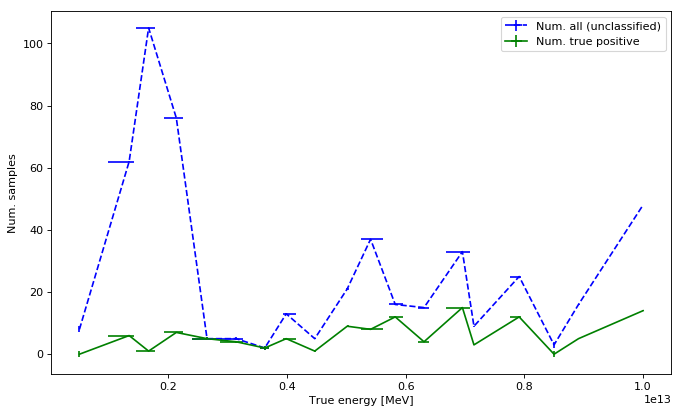

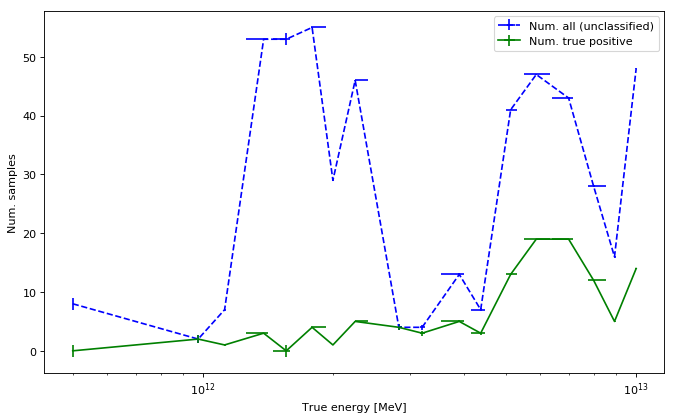

In [231]:
plt.close('all')
for xscale in ('linear', 'log'):
    fig, ax = plt.subplots()
    fig, ax, errbr_num_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy, 
            plotted_stat='num_positive', num_steps = 20, xscale=xscale,
            xlabel = 'True energy [MeV]', ylabel = 'Num. all (unclassified)', label='Num. all (unclassified)',
            figsize = (10,6), errorbar_attrs=dict(linestyle='--', color='blue'), 
            ax=ax, show=False)
    fig, ax, errbr_num_true_positive = \
        plot_efficiency_stat(
            extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy, 
            plotted_stat='num_true_positive', num_steps = 20, xscale=xscale,
            xlabel='True energy [MeV]', ylabel = 'Num. true positive', label='Num. true positive',
            figsize=(10,6), errorbar_attrs=dict(linestyle='-', color='green'),
            ax=ax, show=False)
    ax.set_ylabel('Num. samples')
    ax.legend()
    plt.show()

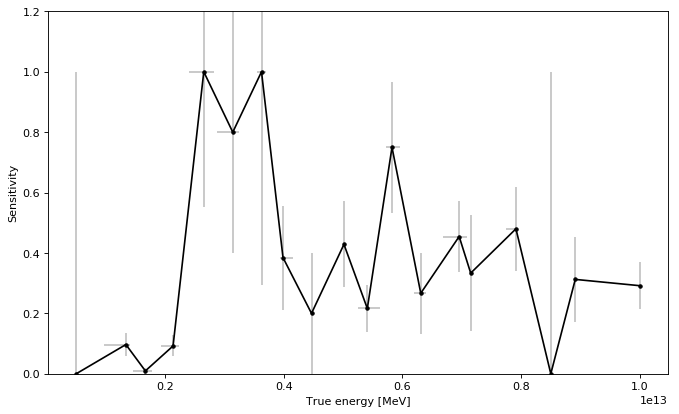

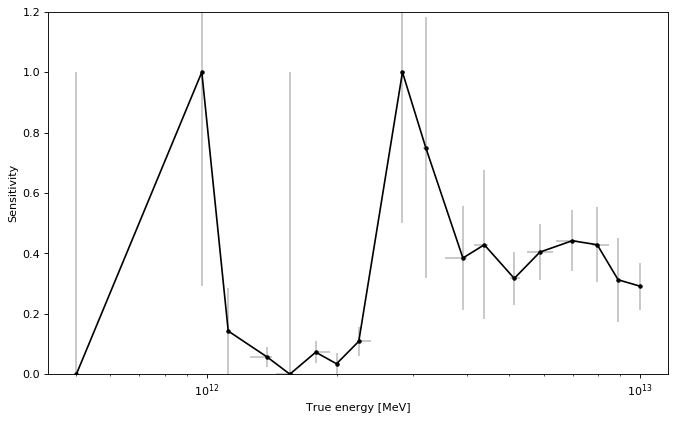

In [232]:
plt.close('all')
for xscale in ('linear', 'log'):
    plot_efficiency_stat(extra_trees_cls_on_train_rfecv__simu_bgf1_unclassified__numbers_by_energy, 
                         plotted_stat='sensitivity', plotted_yerr_stat='sensitivity_err_mario', num_steps = 20, xscale=xscale,
                         xlabel = 'True energy [MeV]', ylabel = 'Sensitivity', 
                         figsize = (10,6), ylim=(0,1.2))